In [3]:
#use the Q2 2016 data first
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
fs = 18
fs_ = 20
_fs = 16
thresh_losses = np.arange(0.85,0.99,0.01)

def binary_rec(labels, pred, thresh=0.85):
    pred_pos = 0 #values I've predicted above a threshold (numerator)
    all_pos = 0 #all true positives in test data (denominator)
    for i in range(len(labels)):
        if labels[i] >= thresh:
            all_pos += 1
            if pred[i] >= thresh:
                pred_pos += 1
    if all_pos == 0:
        return(np.nan)
    else:
        return(float(pred_pos)/float(all_pos))
    
def binary_prec(labels, pred, thresh=0.85):
    pred_pos = 0 #values I've predicted above a threshold (denominator)
    true_pos = 0 #positives I've correctly predicted (numerator)
    for i in range(len(pred)):
        if pred[i] >= thresh:
            pred_pos += 1
            if labels[i] >= thresh:
                true_pos += 1
    if pred_pos == 0:
        return(np.nan)
    else:
        return(float(true_pos)/float(pred_pos))

def thresh_loss(labels, pred, thresh=0.85):
    out = []
    for i in range(len(labels)):
        if pred[i] >= thresh or labels[i] >= thresh:
            loss = np.abs(labels[i] - pred[i])
            out.append(loss)
    if len(out) == 0:
        out = np.nan
    else:
        pass
    return(np.nanmean(out))

def eval_perf_dropoff(labels, pred):
    thresh_losses = np.arange(0.85,0.99,0.01)
    
    out_prec = []
    out_rec = []
    out_loss = []
    out_false_pos = []
    out_false_neg = []
    out_raw_false_pos = []
    out_raw_false_neg = []
    
    for t in thresh_losses:
        out_prec.append(binary_prec(labels, pred, t))
        out_rec.append(binary_rec(labels, pred, t))
        out_loss.append(thresh_loss(labels, pred, t))
        out_false_pos.append(binary_false_pos(labels, pred, t))
        out_false_neg.append(binary_false_neg(labels, pred, t))
        out_raw_false_pos.append(raw_binary_false_pos(labels, pred, t))
        out_raw_false_neg.append(raw_binary_false_neg(labels, pred, t))
        
    return(out_prec, out_rec, out_loss, out_false_pos, out_false_neg, out_raw_false_pos, out_raw_false_neg)

def nn_eval_perf_dropoff(mname, class_path, test_data_path):
    random.seed(45)
    torch.manual_seed(45)
    
    #load model
    path = "/home/chase/projects/peakload/data/nets/models/"
    sys.path.append(class_path)
    nnmodel = torch.load(path + mname)
    
    #load test data
    files = os.listdir(test_data_path)
    normed_test_data_pairs = []
    for f in files:
        with open(test_data_path + "/" + f, 'rb') as d:
            normed_test_data_pairs.append(pickle.load(d))
            
    #do prediction on test data
    inputs, labels = torch_reshape_data(normed_test_data_pairs)
    labels = Variable(labels.cuda())
    inputs = Variable(inputs.cuda())
    outputs = nnmodel(inputs)

    labels = labels.data.cpu().numpy()
    outputs = outputs.data.cpu().numpy()
    
    #evaluate
    prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
    raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

    for i in range(outputs.shape[0]):
        nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
        prec[i,:] = np.array(nout_prec)
        rec[i,:] = np.array(nout_rec)
        loss[i,:] = np.array(nout_loss)
        false_pos[i,:] = np.array(nout_false_pos)
        false_neg[i,:] = np.array(nout_false_neg)
        raw_false_pos[i,:] = np.array(nout_raw_false_pos)
        raw_false_neg[i,:] = np.array(nout_raw_false_neg)
        
    lnout_prec = np.nanmean(prec, axis=0)
    lnout_rec = np.nanmean(rec, axis=0)
    lnout_loss = np.nanmean(loss, axis=0)
    lnout_false_pos = np.nanmean(false_pos, axis=0)
    lnout_false_neg = np.nanmean(false_neg, axis=0)
    lnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
    lnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)
    
    return(lnout_prec, lnout_rec, lnout_loss, lnout_false_pos, lnout_false_neg, lnout_raw_false_pos, lnout_raw_false_neg)

def torch_reshape_data(databatch):
    #flattens array inputs for a single list of training, target pairs
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

def binary_false_pos(labels, pred, thresh=0.85):
    false_pos = 0
    for i in range(len(labels)):
        if pred[i] >= thresh and labels[i] < thresh:
            false_pos += 1
    g1 = sum([1 for j in labels if j >= thresh])
    g2 = sum([1 for j in pred if j >= thresh])
    greater = g1 + g2
    if greater == 0:
        return(np.nan)
    else:
        return(float(false_pos)/float(greater))
    
def raw_binary_false_pos(labels, pred, thresh=0.85):
    false_pos = 0
    for i in range(len(labels)):
        if pred[i] >= thresh and labels[i] < thresh:
            false_pos += 1
    return(float(false_pos))

def binary_false_neg(labels, pred, thresh=0.85):
    false_neg = 0
    for i in range(len(labels)):
        if pred[i] < thresh and labels[i] >= thresh:
            false_neg += 1
    g1 = sum([1 for j in labels if j >= thresh])
    g2 = sum([1 for j in pred if j >= thresh])
    greater = g1 + g2
    if greater == 0:
        return(np.nan)
    else:
        return(float(false_neg)/float(greater))
    
def raw_binary_false_neg(labels, pred, thresh=0.85):
    false_neg = 0
    for i in range(len(labels)):
        if pred[i] < thresh and labels[i] >= thresh:
            false_neg += 1
    return(float(false_neg))

In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
#ANNUAL PEAKS

In [5]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]


570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


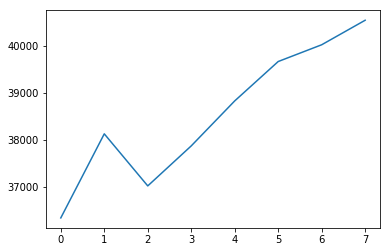

In [6]:
#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

In [7]:
yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]

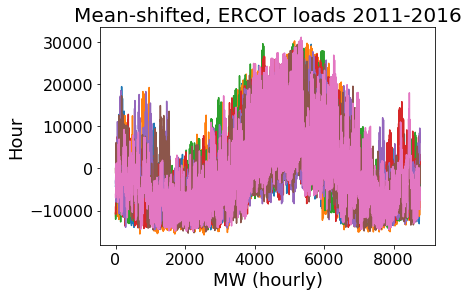

In [8]:
ax = plt.axes()
plt.title("Mean-shifted, ERCOT loads 2011-2016", fontsize=fs_)
plt.ylabel("Hour", fontsize=fs)
plt.xlabel("MW (hourly)", fontsize=fs)
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
for i in range(7):
    plt.plot(yearly_loads[i,:])
plt.show()

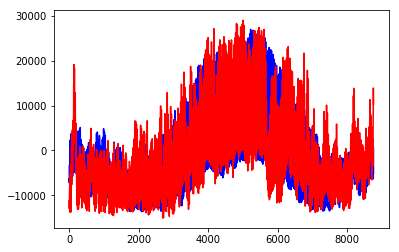

In [9]:
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue")
plt.plot(test, color="red")

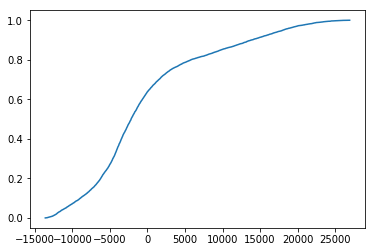

In [13]:
power_vals = np.arange(np.min(model),np.max(model),0.5)
empirical_cdf = []
for p in power_vals:
    greater = np.sum([ 1 for k in model[:,] if k >= p ])/float(model.shape[0])
    empirical_cdf.append(1.0 - greater)
    
#plt.plot(sorted(model))
#plt.plot(sorted(test))
plt.plot(power_vals, empirical_cdf)

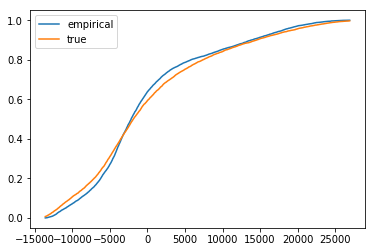

In [16]:
true_cdf = []
for p in power_vals:
    greater = np.sum([ 1 for k in test[:,] if k >= p ])/float(model.shape[0])
    true_cdf.append(1.0 - greater)
    


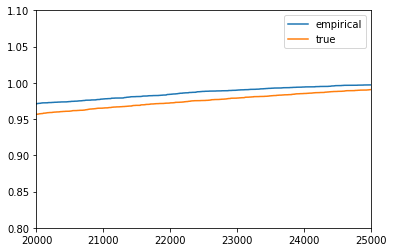

In [18]:
plt.plot(power_vals, empirical_cdf, label="empirical")
plt.plot(power_vals, true_cdf, label="true")
plt.xlim(20000, 25000)
plt.ylim(0.8,1.1)
plt.legend()
plt.show()

In [23]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

In [24]:
model_ranks = []
test_ranks = []

for val in test:
    idx = find_nearest_idx(power_vals, val)
    mod = empirical_cdf[idx]
    model_ranks.append(mod)
    true = true_cdf[idx]
    test_ranks.append(true)
    


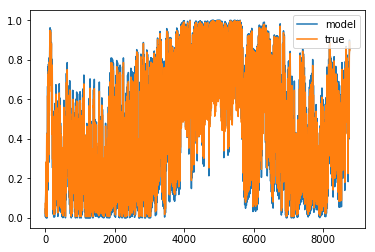

In [27]:
plt.plot(model_ranks, label="model")
plt.plot(test_ranks, label="true")
plt.legend()
plt.show()

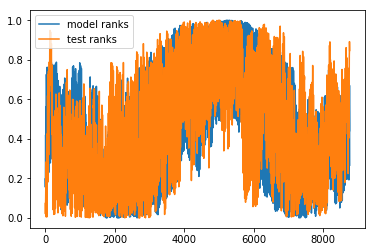

In [8]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

for i in range(model_ranks.shape[0]):
    greater = np.sum([ 1 for k in model[:,] if k >= model[i,] ])/float(model.shape[0])
    model_ranks[i,0] = 1.0 - greater
    
for i in range(test_ranks.shape[0]):
    greater = np.sum([ 1 for k in test[:,] if k >= test[i,] ])/float(test.shape[0])
    test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks, label="model ranks")
plt.plot(test_ranks, label="test ranks")
plt.legend()

In [9]:
out_prec, out_rec, out_loss, out_false_pos, out_false_neg, out_raw_false_pos, out_raw_false_neg = eval_perf_dropoff(test_ranks, model_ranks)

In [11]:
#compare to a neural net
#load only
path = "/home/chase/projects/peakload/data/nets/models/"
#mname = 'triple_hidden_6822.pt' #L1 loss model, 300 epochs
mname = 'triple_hidden_6772.pt' #EW loss model, 300 epochs, same random seed

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

In [12]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test"
files = os.listdir(test_data_path)
normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        normed_test_data_pairs.append(pickle.load(d))

In [13]:
#do prediction on test data
inputs, labels = torch_reshape_data(normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [14]:
prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)
    raw_false_pos[i,:] = np.array(nout_raw_false_pos)
    raw_false_neg[i,:] = np.array(nout_raw_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


In [15]:
lnout_prec = np.nanmean(prec, axis=0)
lnout_rec = np.nanmean(rec, axis=0)
lnout_loss = np.nanmean(loss, axis=0)
lnout_false_pos = np.nanmean(false_pos, axis=0)
lnout_false_neg = np.nanmean(false_neg, axis=0)
lnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
lnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)

In [16]:
#compare to a neural net
#load only monthly model
path = "/home/chase/projects/peakload/data/nets/models/"
#mname = 'triple_hidden_6822.pt' #L1 loss model, 300 epochs
mname = 'triple_hidden_6772.pt' #EW loss model, 300 epochs, same random seed

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

In [17]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test"
files = os.listdir(test_data_path)
normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        normed_test_data_pairs.append(pickle.load(d))

In [18]:
#do prediction on test data
inputs, labels = torch_reshape_data(normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [19]:
prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)
    raw_false_pos[i,:] = np.array(nout_raw_false_pos)
    raw_false_neg[i,:] = np.array(nout_raw_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


In [20]:
elnout_prec = np.nanmean(prec, axis=0)
elnout_rec = np.nanmean(rec, axis=0)
elnout_loss = np.nanmean(loss, axis=0)
elnout_false_pos = np.nanmean(false_pos, axis=0)
elnout_false_neg = np.nanmean(false_neg, axis=0)
elnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
elnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)

In [21]:
#with weather data
path = "/home/chase/projects/peakload/data/nets/models/"
#mname = 'triple_hidden_2593.pt'
mname = 'triple_hidden_3120.pt'

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

In [22]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/regional_formatted/load_features_wplus/test"
files = os.listdir(test_data_path)
weather_normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        weather_normed_test_data_pairs.append(pickle.load(d))

In [23]:
#do prediction on test data
inputs, labels = torch_reshape_data(weather_normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [24]:
prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)
    raw_false_pos[i,:] = np.array(nout_raw_false_pos)
    raw_false_neg[i,:] = np.array(nout_raw_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


In [25]:
wnout_prec = np.nanmean(prec, axis=0)
wnout_rec = np.nanmean(rec, axis=0)
wnout_loss = np.nanmean(loss, axis=0)
wnout_false_pos = np.nanmean(false_pos, axis=0)
wnout_false_neg = np.nanmean(false_neg, axis=0)
wnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
wnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)

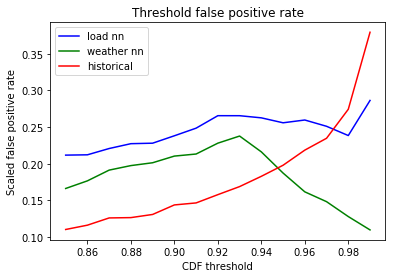

In [36]:
plt.plot(thresh_losses, elnout_false_pos, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_false_pos, color="green", label="weather nn")
plt.plot(thresh_losses, out_false_pos, color="red", label = "historical")
plt.title("Threshold false positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false positive rate")
plt.legend()

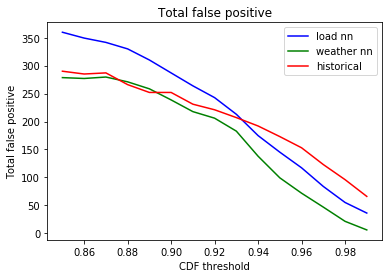

In [37]:
plt.plot(thresh_losses, elnout_raw_false_pos*365, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_raw_false_pos*365, color="green", label="weather nn")
plt.plot(thresh_losses, out_raw_false_pos, color="red", label = "historical")
plt.title("Total false positive")
plt.xlabel("CDF threshold")
plt.ylabel("Total false positive")
plt.legend()

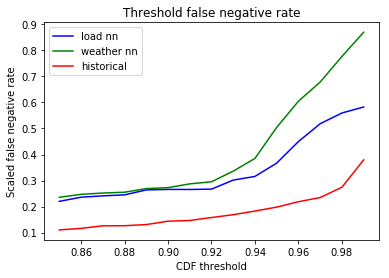

In [38]:
plt.plot(thresh_losses, elnout_false_neg, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_false_neg, color="green", label="weather nn")
plt.plot(thresh_losses, out_false_neg, color="red", label="historical")
plt.title("Threshold false negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false negative rate")
plt.legend()

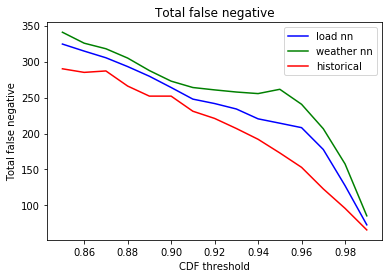

In [39]:
plt.plot(thresh_losses, elnout_raw_false_neg*365, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_raw_false_neg*365, color="green", label="weather nn")
plt.plot(thresh_losses, out_raw_false_neg, color="red", label="historical")
plt.title("Total false negative")
plt.xlabel("CDF threshold")
plt.ylabel("Total false negative")
plt.legend()

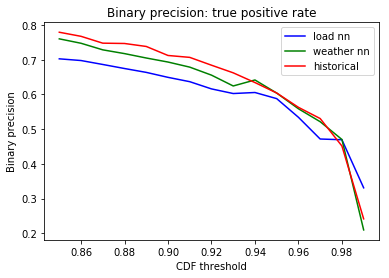

In [40]:
plt.plot(thresh_losses, elnout_prec, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_prec, color="green", label="weather nn")
plt.plot(thresh_losses, out_prec, color="red", label = "historical")
plt.title("Binary precision: true positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary precision")
plt.legend()

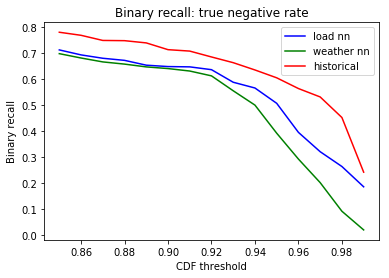

In [41]:
plt.plot(thresh_losses, elnout_rec, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_rec, color="green", label="weather nn")
plt.plot(thresh_losses, out_rec, color="red", label = "historical")
plt.title("Binary recall: true negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary recall")
plt.legend()

Text(0,0.5,'L1 Loss')

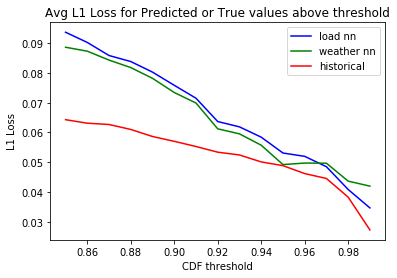

In [42]:
plt.plot(thresh_losses, elnout_loss, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_loss, color="green", label="weather nn")
plt.plot(thresh_losses, out_loss, color="red", label="historical")
plt.legend()
plt.title("Avg L1 Loss for Predicted or True values above threshold")
plt.xlabel("CDF threshold")
plt.ylabel("L1 Loss")

# MONTHLY

In [10]:
#MONTHLY PEAKS
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


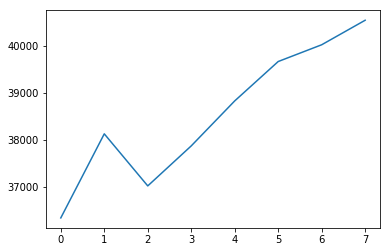

In [11]:
#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

In [12]:
yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]

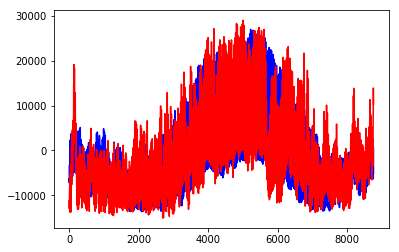

In [13]:
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue")
plt.plot(test, color="red")

In [14]:
dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for j in range(len(dayspermonth)):
    hstart = 0 
    for k in range(j):
        hstart += dayspermonth[k]*24
    hend = hstart + dayspermonth[j]*24
    
    print(hstart, hend)

0 744
744 1416
1416 2160
2160 2880
2880 3624
3624 4344
4344 5088
5088 5832
5832 6552
6552 7296
7296 8016
8016 8760


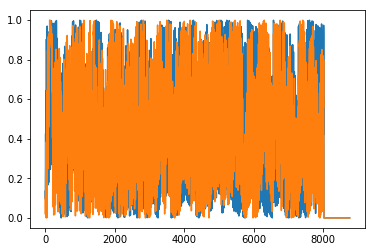

In [15]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

dayspermonth = [31, 28, 31, 30, 31, 30, 31, 30, 31, 30, 31]

for j in range(len(dayspermonth)):
    hstart = 0 
    for k in range(j):
        hstart += dayspermonth[k]*24
    hend = hstart + dayspermonth[j]*24
    
    for i in range(hstart,hend+1):
        greater = np.sum([ 1 for k in model[hstart:hend,] if k >= model[i,] ])/float(dayspermonth[j]*24)
        model_ranks[i,0] = 1.0 - greater
    
    for i in range(hstart,hend+1):
        greater = np.sum([ 1 for k in test[hstart:hend,] if k >= test[i,] ])/float(dayspermonth[j]*24)
        test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks)
plt.plot(test_ranks)

In [16]:
mout_prec, mout_rec, mout_loss, mout_false_pos, mout_false_neg, mout_raw_false_pos, mout_raw_false_neg = eval_perf_dropoff(test_ranks, model_ranks)

In [86]:
#compare to a neural net
#load only monthly model
path = "/home/chase/projects/peakload/data/nets/models/"
mname = 'triple_hidden_7507.pt'

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

In [87]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features/test"
files = os.listdir(test_data_path)
normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        normed_test_data_pairs.append(pickle.load(d))

In [88]:
#do prediction on test data
inputs, labels = torch_reshape_data(normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [89]:
prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)
    raw_false_pos[i,:] = np.array(nout_raw_false_pos)
    raw_false_neg[i,:] = np.array(nout_raw_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


In [90]:
lnout_prec = np.nanmean(prec, axis=0)
lnout_rec = np.nanmean(rec, axis=0)
lnout_loss = np.nanmean(loss, axis=0)
lnout_false_pos = np.nanmean(false_pos, axis=0)
lnout_false_neg = np.nanmean(false_neg, axis=0)
lnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
lnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)

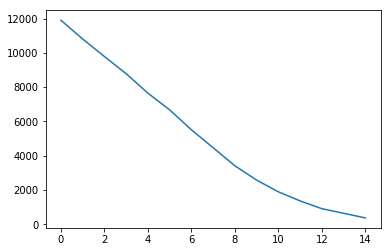

In [91]:
plt.plot(np.nansum(raw_false_pos, axis=0))

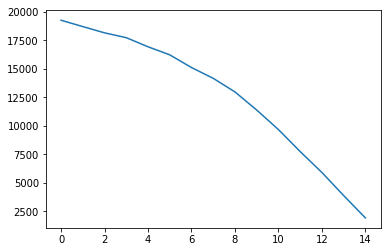

In [92]:
plt.plot(np.nansum(raw_false_neg, axis=0))

In [93]:
#with weather data
path = "/home/chase/projects/peakload/data/nets/models/"
mname = 'tanh_deep_5731.pt'

sys.path.append("/home/chase/projects/peakload/src/python/nets/tanh_deep")

nnmodel = torch.load(path + mname)

In [94]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/formatted_load_features/test"
files = os.listdir(test_data_path)
weather_normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        weather_normed_test_data_pairs.append(pickle.load(d))

In [95]:
#do prediction on test data
inputs, labels = torch_reshape_data(weather_normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [96]:
outputs.shape[1], thresh_losses.shape[0]

(24, 15)

In [97]:
prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
raw_false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)
    raw_false_pos[i,:] = np.array(nout_raw_false_pos)
    raw_false_neg[i,:] = np.array(nout_raw_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


In [98]:
wnout_prec = np.nanmean(prec, axis=0)
wnout_rec = np.nanmean(rec, axis=0)
wnout_loss = np.nanmean(loss, axis=0)
wnout_false_pos = np.nanmean(false_pos, axis=0)
wnout_false_neg = np.nanmean(false_neg, axis=0)
wnout_raw_false_pos = np.nanmean(raw_false_pos, axis=0)
wnout_raw_false_neg = np.nanmean(raw_false_neg, axis=0)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


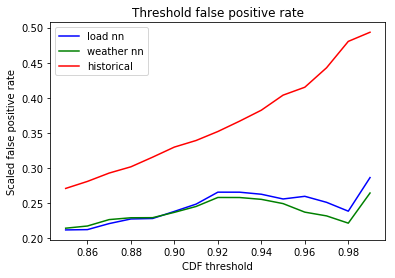

In [73]:
plt.plot(thresh_losses, lnout_false_pos, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_false_pos, color="green", label="weather nn")
plt.plot(thresh_losses, out_false_pos, color="red", label = "historical")
plt.title("Threshold false positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false positive rate")
plt.legend()
plt.show()

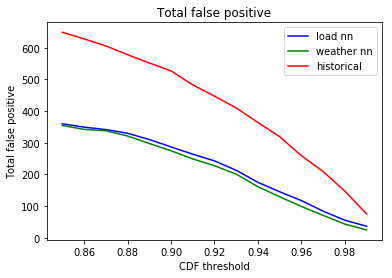

In [74]:
plt.plot(thresh_losses, lnout_raw_false_pos*365, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_raw_false_pos*365, color="green", label="weather nn")
plt.plot(thresh_losses, out_raw_false_pos, color="red", label = "historical")
plt.title("Total false positive")
plt.xlabel("CDF threshold")
plt.ylabel("Total false positive")
plt.legend()
plt.show()

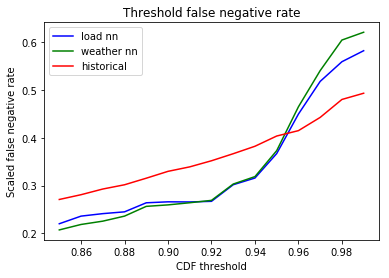

In [75]:
plt.plot(thresh_losses, lnout_false_neg, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_false_neg, color="green", label="weather nn")
plt.plot(thresh_losses, out_false_neg, color="red", label="historical")
plt.title("Threshold false negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false negative rate")
plt.legend()
plt.show()

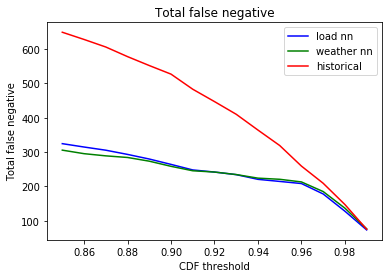

In [76]:
plt.plot(thresh_losses, lnout_raw_false_neg*365, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_raw_false_neg*365, color="green", label="weather nn")
plt.plot(thresh_losses, out_raw_false_neg, color="red", label="historical")
plt.title("Total false negative")
plt.xlabel("CDF threshold")
plt.ylabel("Total false negative")
plt.legend()
plt.show()

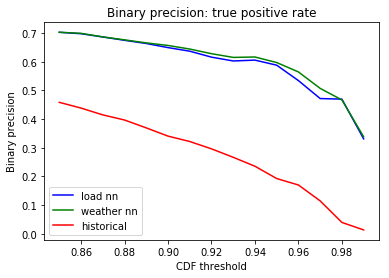

In [77]:
plt.plot(thresh_losses, lnout_prec, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_prec, color="green", label="weather nn")
plt.plot(thresh_losses, out_prec, color="red", label = "historical")
plt.title("Binary precision: true positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary precision")
plt.legend()
plt.show()

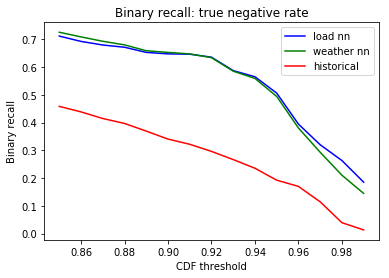

In [78]:
plt.plot(thresh_losses, lnout_rec, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_rec, color="green", label="weather nn")
plt.plot(thresh_losses, out_rec, color="red", label = "historical")
plt.title("Binary recall: true negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary recall")
plt.legend()
plt.show()

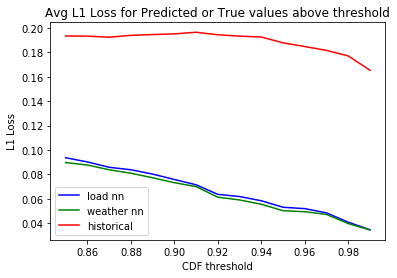

In [79]:
plt.plot(thresh_losses, lnout_loss, color="blue", label="load nn")
plt.plot(thresh_losses, wnout_loss, color="green", label="weather nn")
plt.plot(thresh_losses, out_loss, color="red", label="historical")
plt.legend()
plt.title("Avg L1 Loss for Predicted or True values above threshold")
plt.xlabel("CDF threshold")
plt.ylabel("L1 Loss")
plt.show()

# LOSS FUNCTION COMPARISON

In [6]:
#ablation study
#ercot load model L1 loss, ercot load model EW loss
#regional load model L1 loss, regional load model EW loss

class_path = "/home/chase/projects/peakload/src/python/nets/triple_hidden"

modelids = [2519, 9106, 1864, 7411]
#9106 EW, 2519 L1 regional formatted
#1864 EW, 7411 L1 ercot only

modelparams = {}

for mid in modelids:
    with open(class_path + "/triple_hidden_" + str(mid) + "_params.pck", 'rb') as d:
        modelparams[mid] = pickle.load(d)

sys.path.append(class_path)

In [9]:
#nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg, nout_raw_false_pos, nout_raw_false_neg
results_2519 = nn_eval_perf_dropoff("triple_hidden_2519.pt", "/home/chase/projects/peakload/src/python/nets/triple_hidden", "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test")
results_9106 = nn_eval_perf_dropoff("triple_hidden_9106.pt", "/home/chase/projects/peakload/src/python/nets/triple_hidden", "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test")
results_7411 = nn_eval_perf_dropoff("triple_hidden_7411.pt", "/home/chase/projects/peakload/src/python/nets/triple_hidden", "/home/chase/projects/peakload/data/ercot/formatted/load_features/test")
results_1864 = nn_eval_perf_dropoff("triple_hidden_1864.pt", "/home/chase/projects/peakload/src/python/nets/triple_hidden", "/home/chase/projects/peakload/data/ercot/formatted/load_features/test")

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


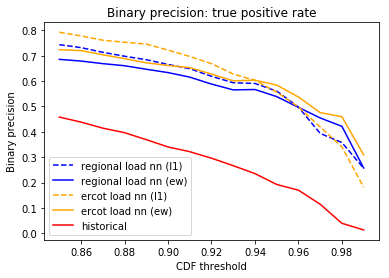

In [25]:
plt.plot(thresh_losses, results_2519[0], ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[0], color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[0], ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[0], color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_prec, color="red", label = "historical")
plt.title("Binary precision: true positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary precision")
plt.legend()

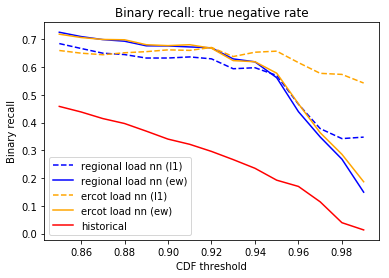

In [26]:
plt.plot(thresh_losses, results_2519[1], ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[1], color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[1], ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[1], color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_rec, color="red", label = "historical")
plt.title("Binary recall: true negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary recall")
plt.legend()

Text(0,0.5,'L1 Loss')

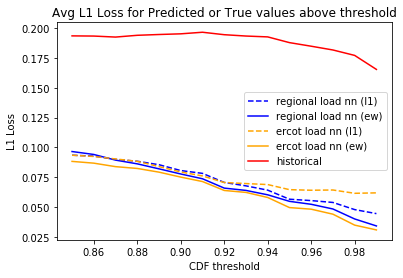

In [27]:
plt.plot(thresh_losses, results_2519[2], ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[2], color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[2], ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[2], color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_loss, color="red", label = "historical")
plt.legend()
plt.title("Avg L1 Loss for Predicted or True values above threshold")
plt.xlabel("CDF threshold")
plt.ylabel("L1 Loss")

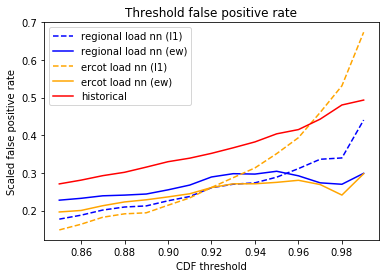

In [84]:
plt.plot(thresh_losses, results_2519[3], ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[3], color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[3], ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[3], color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_false_pos, color="red", label = "historical")
plt.title("Threshold false positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false positive rate")
plt.legend()

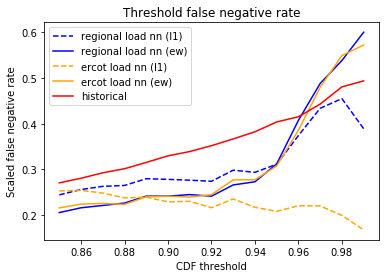

In [83]:
plt.plot(thresh_losses, results_2519[4], ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[4], color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[4], ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[4], color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_false_neg, color="red", label = "historical")
plt.title("Threshold false negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false negative rate")
plt.legend()

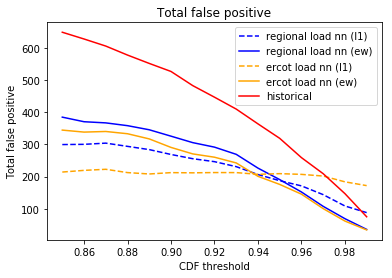

In [30]:
plt.plot(thresh_losses, results_2519[5]*365, ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[5]*365, color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[5]*365, ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[5]*365, color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_raw_false_pos, color="red", label = "historical")
plt.title("Total false positive")
plt.xlabel("CDF threshold")
plt.ylabel("Total false positive")
plt.legend()

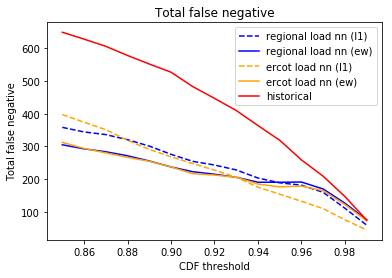

In [33]:
plt.plot(thresh_losses, results_2519[6]*365, ls="--", color="blue", label="regional load nn (l1)")
plt.plot(thresh_losses, results_9106[6]*365, color="blue", label="regional load nn (ew)")
plt.plot(thresh_losses, results_7411[6]*365, ls="--", color="orange", label="ercot load nn (l1)")
plt.plot(thresh_losses, results_1864[6]*365, color="orange", label="ercot load nn (ew)")
plt.plot(thresh_losses, out_raw_false_neg, color="red", label = "historical")
plt.title("Total false negative")
plt.xlabel("CDF threshold")
plt.ylabel("Total false negative")
plt.legend()